In [1]:
# importing libraries
import pandas as pd
import numpy as np
import datetime 
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings(action="ignore")

# Modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,precision_recall_curve,roc_curve
from catboost import CatBoostClassifier



In [2]:
train_df=pd.read_csv(r'C:\Users\LInBlue\Desktop\Interview Preparation\Dataset\av\train.csv')
test_df=pd.read_csv(r'C:\Users\LInBlue\Desktop\Interview Preparation\Dataset\av\test.csv')
sample=pd.read_csv(r'C:\Users\LInBlue\Desktop\Interview Preparation\Dataset\av\sample.csv')

In [3]:
def data_exploration(df):
    print("----------Shape of Data----------------------------------------")
    print(df.shape)
    print("----------Top-5- Record---------------------------------------")
    print(df.head(5))
    print("-----------Information----------------------------------------")
    print(df.info())
    print("-----------Data Types----------------------------------------")
    print(df.dtypes)
    print("----------Missing value--------------------------------------")
    print(df.isnull().sum())
    print("----------Null value------------------------------------------")
    print(df.isna().sum())
    print("---------Categorical Columns---------------------------------")
    print([col for col in df.columns if df[col].dtypes=='object'])
    print("---------Numerical Columns---------------------------------")
    print([col for col in df.columns if df[col].dtypes!='object'])
    print("---------Unique Values--------------------------------------")
    print([(col,df[col].nunique()) for col in df.columns])
        

In [4]:
data_exploration(train_df)

----------Shape of Data----------------------------------------
(50882, 14)
----------Top-5- Record---------------------------------------
   ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  Upper_Age  \
0   1        C3         3213            Rented          Individual         36   
1   2        C5         1117             Owned               Joint         75   
2   3        C5         3732             Owned          Individual         32   
3   4       C24         4378             Owned               Joint         52   
4   5        C8         2190            Rented          Individual         44   

   Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         36        No               X1                     14+   
1         22        No               X2                     NaN   
2         32        No              NaN                     1.0   
3         48        No               X1                     14+   
4         44        No               X2

In [5]:
data_exploration(test_df)

----------Shape of Data----------------------------------------
(21805, 13)
----------Top-5- Record---------------------------------------
      ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  \
0  50883        C1          156             Owned          Individual   
1  50884        C4            7             Owned               Joint   
2  50885        C1          564            Rented          Individual   
3  50886        C3         1177            Rented          Individual   
4  50887        C1          951             Owned          Individual   

   Upper_Age  Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         30         30        No              NaN                     6.0   
1         69         68       Yes               X1                     3.0   
2         28         28        No               X3                     2.0   
3         23         23        No               X3                     3.0   
4         75         75        N

### Missing Value treatment

In [6]:
train_df.rename(columns={'Health Indicator':'Health_Indicator'},inplace=True)
test_df.rename(columns={'Health Indicator':'Health_Indicator'},inplace=True)

In [7]:
train_df['Health_Indicator']=train_df['Health_Indicator'].fillna('X1')
test_df['Health_Indicator']=test_df['Health_Indicator'].fillna('X1')

In [8]:
train_df['Holding_Policy_Type']=train_df['Holding_Policy_Type'].fillna(0.0)
test_df['Holding_Policy_Type']=test_df['Holding_Policy_Type'].fillna(0.0)

In [9]:
train_df['Holding_Policy_Duration'][train_df['Holding_Policy_Duration']=='14+']=15.0
test_df['Holding_Policy_Duration'][test_df['Holding_Policy_Duration']=='14+']=15.0

In [10]:
train_df['Holding_Policy_Duration']=train_df['Holding_Policy_Duration'].astype(np.float32)
test_df['Holding_Policy_Duration']=test_df['Holding_Policy_Duration'].astype(np.float32)

In [11]:
train_df['Holding_Policy_Duration']=train_df['Holding_Policy_Duration'].fillna(0.0)
test_df['Holding_Policy_Duration']=test_df['Holding_Policy_Duration'].fillna(0.0)

### Feature Enginnering

In [12]:
target=train_df['Response']
train_df.drop(['ID','Response'],axis=1,inplace=True)
test_df.drop('ID',axis=1,inplace=True)

In [13]:
def feature_engineering(df):
    
    
    df['Accomodation_and_RecoType']= df['Accomodation_Type']+'_'+df['Reco_Insurance_Type']
### Insurance type and Spouse
    df['Spouse_and_RecoType']= df['Is_Spouse']+'_'+df['Reco_Insurance_Type']
### Reco policy cat and REco_Insurance type
    df['Reco_Policy_Cat']=df['Reco_Policy_Cat'].astype(str)
    df['InsuranceType_and_PolicyCat']= df['Reco_Insurance_Type']+'_'+df['Reco_Policy_Cat']
### Health Indicator and Recommended policy cat
    df['Health_and_PolicyCat']= df['Health_Indicator']+'_'+df['Reco_Policy_Cat']
### Holding policy type and Recommended policy cat
    df['Holding_Policy_Type']=df['Holding_Policy_Type'].astype(str)
    df['HoldingType_and_PolicyCat']= df['Holding_Policy_Type']+'_'+df['Reco_Policy_Cat']
### Holding policy type and Holding_Policy_Duration
    df['Holding_Policy_Duration']=df['Holding_Policy_Duration'].astype(str)
    df['HoldingType_and_Duration']= df['Holding_Policy_Type']+'_'+df['Holding_Policy_Duration']

    new_cat=['HoldingType_and_Duration','Accomodation_and_RecoType','Spouse_and_RecoType','InsuranceType_and_PolicyCat','Health_and_PolicyCat','HoldingType_and_PolicyCat']
    # Aggregation based on Cat Columns 
    
    city_agg = df.groupby(['City_Code']).agg({'Lower_Age': ['mean', 'max', 'min','std'],
                                                     'Reco_Policy_Premium': ['mean', 'max', 'min','std','sum'], 
                                                     'Region_Code': ['nunique','count'], 
                                                     'Accomodation_Type': ['nunique','count'],
                                                     'Reco_Insurance_Type': ['nunique','count'] ,
                                                     'Health_Indicator': ['nunique','count'] ,
                                                     'Holding_Policy_Type': ['nunique','count'] ,
                                                     'Reco_Policy_Cat': ['nunique','count'] ,
                                                     })
    city_agg.columns = ['city_agg' + '_'.join(c).strip('_') for c in city_agg.columns]
    df = pd.merge(df, city_agg, on = ['City_Code'], how='left')

    
    city_region = df.groupby(['City_Code','Region_Code']).agg({'Lower_Age': ['mean', 'max', 'min','std'],
                                                     'Reco_Policy_Premium': ['mean', 'max', 'min','std','sum'],  
                                                     'Accomodation_Type': ['nunique','count'],
                                                     'Reco_Insurance_Type': ['nunique','count'] ,
                                                     'Health_Indicator': ['nunique','count'] ,
                                                     'Holding_Policy_Type': ['nunique','count'] ,
                                                     'Reco_Policy_Cat': ['nunique','count'] ,
                                                     })
    city_region.columns = ['city_region' + '_'.join(c).strip('_') for c in city_region.columns]
    df = pd.merge(df, city_region, on = ['City_Code','Region_Code'], how='left')

    
    city_policy_cat = df.groupby(['City_Code','Reco_Policy_Cat']).agg({'Lower_Age': ['mean', 'max', 'min','std'],
                                                     'Reco_Policy_Premium': ['mean', 'max', 'min','std','sum'], 
                                                     'Region_Code': ['nunique','count'], 
                                                     'Accomodation_Type': ['nunique','count'],
                                                     'Reco_Insurance_Type': ['nunique','count'] ,
                                                     'Health_Indicator': ['nunique','count'] ,
                                                     'Holding_Policy_Type': ['nunique','count'] 
                                                     })
    city_policy_cat.columns = ['city_policy_cat' + '_'.join(c).strip('_') for c in city_policy_cat.columns]
    df = pd.merge(df, city_policy_cat, on = ['City_Code','Reco_Policy_Cat'], how='left')
    
    policy_type = df.groupby(['Holding_Policy_Type']).agg({'Lower_Age': ['mean', 'max', 'min','std'],
                                                     'Reco_Policy_Premium': ['mean', 'max', 'min','std','sum'], 
                                                     'Region_Code': ['nunique','count'], 
                                                     'Accomodation_Type': ['nunique','count'],
                                                     'Reco_Insurance_Type': ['nunique','count'] ,
                                                     'Health_Indicator': ['nunique','count'] ,
                                                     'City_Code': ['nunique','count'] ,
                                                     })
    policy_type.columns = ['policy_type' + '_'.join(c).strip('_') for c in policy_type.columns]
    df = pd.merge(df, policy_type, on = ['Holding_Policy_Type'], how='left')
    
    Health_Indicator = df.groupby(['Health_Indicator']).agg({'Lower_Age': ['mean', 'max', 'min','std'],
                                                     'Reco_Policy_Premium': ['mean', 'max', 'min','std','sum'],  
                                                     'Region_Code': ['nunique','count'], 
                                                     'Reco_Insurance_Type': ['nunique','count'] ,
                                                     'Accomodation_Type': ['nunique','count'],
                                                     'Holding_Policy_Type': ['nunique','count'] ,
                                                     'City_Code': ['nunique','count'] ,
                                                     })
    Health_Indicator.columns = ['Health_Indicator' + '_'.join(c).strip('_') for c in Health_Indicator.columns]
    df = pd.merge(df, Health_Indicator, on = ['Health_Indicator'], how='left')
    
    for col in new_cat:
        df[f'{col}_Premium_mean']=df.groupby(col)['Reco_Policy_Premium'].transform('mean')
        df[f'{col}_Premium_std']=df.groupby(col)['Reco_Policy_Premium'].transform('std')
        df[f'{col}_Premium_max']=df.groupby(col)['Reco_Policy_Premium'].transform('max')
        df[f'{col}_Premium_min']=df.groupby(col)['Reco_Policy_Premium'].transform('min')
        
    
    return df

In [14]:
train_df=feature_engineering(train_df)
test_df=feature_engineering(test_df)

In [15]:
all_cols_names = train_df.columns
numeric_cols = train_df._get_numeric_data().columns.tolist()
cat_cols=list(set(all_cols_names)-set(numeric_cols))

In [20]:
def cat_model(df,target):
    
    oofs = np.zeros(shape=(len(df)))
    Folds=4
    fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
    i = 1
    for train_index, val_index in fold.split(df, target):
        x_train, x_val = df.iloc[train_index], df.iloc[val_index]
        y_train, y_val = target.iloc[train_index], target.iloc[val_index]
    
        clf =  CatBoostClassifier(n_estimators=5000,random_state=12,eval_metric='AUC',learning_rate=0.08)
        clf.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=50,verbose=200,cat_features=cat_cols)
        
        pred_val = clf.predict_proba(x_val)[:,1]
        oofs[val_index] = pred_val
        print(" Fold : ",i)
        print("\n roc score", roc_auc_score(y_val,pred_val))
        i = i + 1
        
    oof_score = roc_auc_score(target, oofs)
    print(f'\nFinal Auc is : {oof_score}')
    return clf

In [21]:
clf=cat_model(train_df,target)

0:	test: 0.5599554	best: 0.5599554 (0)	total: 256ms	remaining: 21m 18s
200:	test: 0.6994368	best: 0.6994988 (194)	total: 45.8s	remaining: 18m 12s
400:	test: 0.7049251	best: 0.7049251 (400)	total: 1m 32s	remaining: 17m 38s
600:	test: 0.7090036	best: 0.7090036 (600)	total: 2m 23s	remaining: 17m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7107110698
bestIteration = 653

Shrink model to first 654 iterations.
 Fold :  1

 roc score 0.7107110698321519
0:	test: 0.5713880	best: 0.5713880 (0)	total: 261ms	remaining: 21m 43s
200:	test: 0.6983882	best: 0.6983882 (200)	total: 44.6s	remaining: 17m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7032798948
bestIteration = 332

Shrink model to first 333 iterations.
 Fold :  2

 roc score 0.703279894800193
0:	test: 0.5903446	best: 0.5903446 (0)	total: 244ms	remaining: 20m 19s
200:	test: 0.7015027	best: 0.7015426 (198)	total: 44.8s	remaining: 17m 49s
400:	test: 0.7080234	best: 0.7081241 (394)	total: 1

In [23]:
### test prediction
test_preds = clf.predict_proba(test_df)[:,1]

In [22]:
importance_df = pd.DataFrame(clf.get_feature_importance(), columns=['importance'], index=train_df.columns)
importance_df = importance_df.sort_values(by='importance', ascending=False)

In [24]:
importance_df.head()

,importance
HoldingType_and_PolicyCat,9.725126
Reco_Policy_Cat,8.858852
city_regionReco_Policy_Cat_nunique,3.939261
city_policy_catRegion_Code_nunique,2.649002
city_regionLower_Age_mean,2.444137


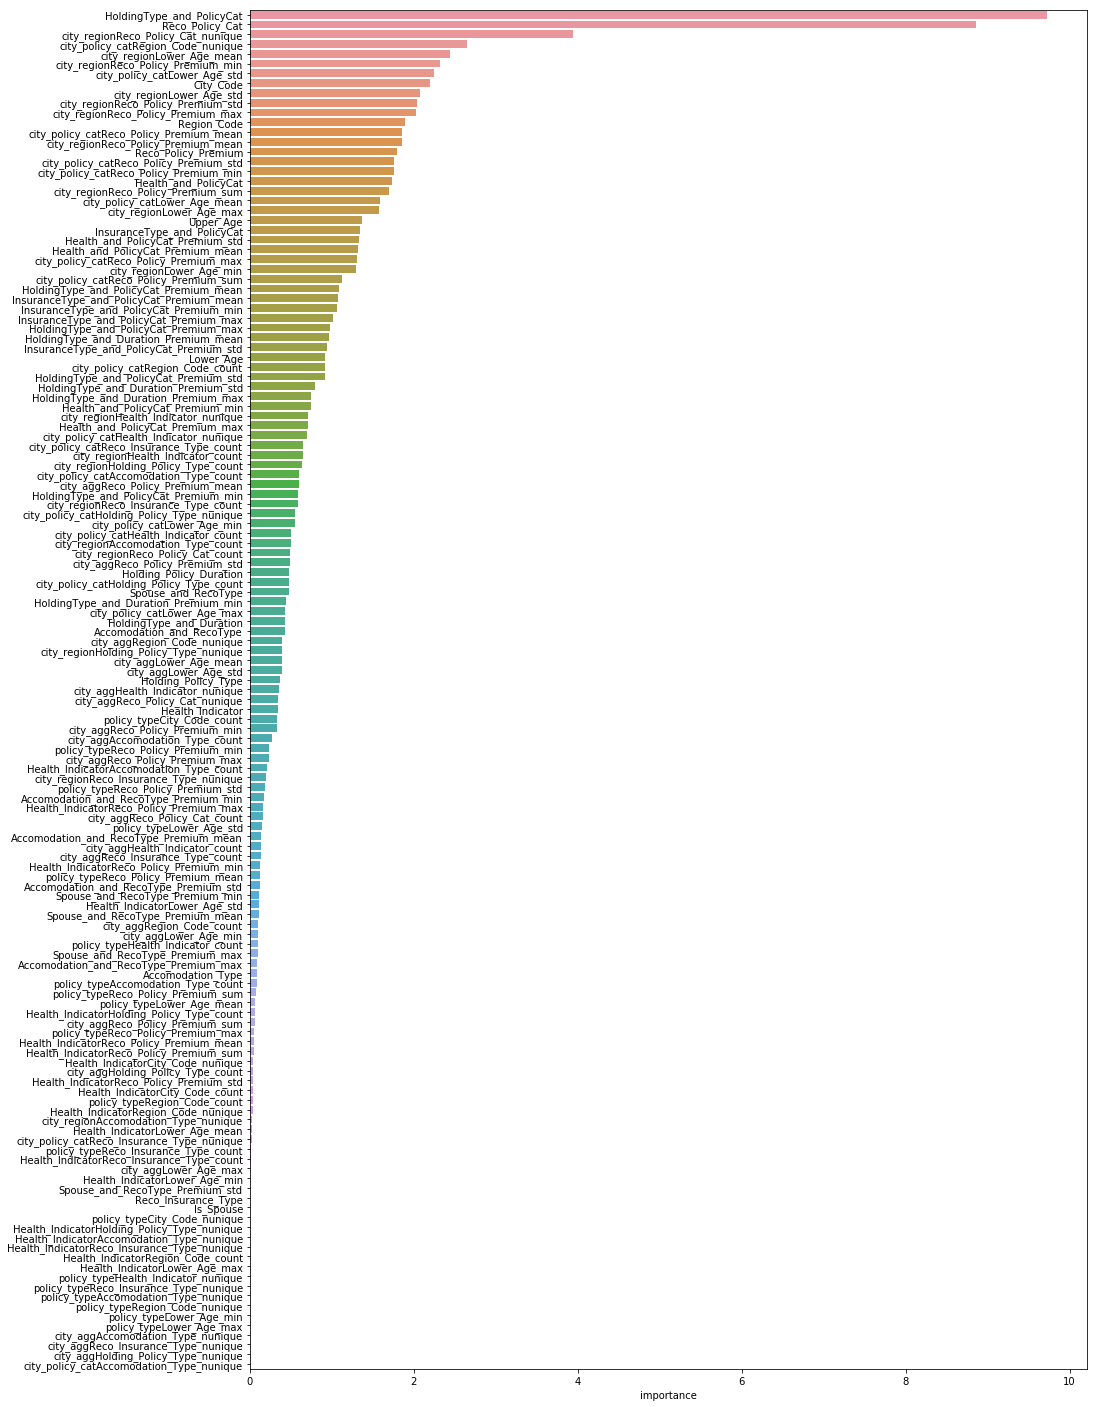

In [26]:
plt.subplots(figsize=(15,25))
sns.barplot(y=importance_df.index,x=importance_df.importance,orient="h")